Well this is the first time I am trying my hands on Audio Classification.In this task we will going to classify ten different audios.I will going to make both machine learning and deep learning model.The different category that we have are:
- disco 
- metal 
- reggae 
- blues
- rock
- classical
- jazz
- hiphop 
- country
- pop

#### About the data
- **genres original** - A collection of 10 genres with 100 audio files each, all having a length of 30 seconds (the famous GTZAN dataset, the MNIST of sounds)
- **images original** - A visual representation for each audio file. One way to classify data is through neural networks. Because NNs (like CNN, what we will be using today) usually take in some sort of image representation, the audio files were converted to Mel Spectrograms to make this possible (we'll be talking about this more in depth later)
- **2 CSV files** - Containing features of the audio files. One file has for each song (30 seconds long) a mean and variance computed over multiple features that can be extracted from an audio file (more in depth later). The other file has the same structure, but the songs were split before into 3 seconds audio files (this way increasing 10 times the amount of data we fuel into our classification models). With data, more is always better.

# Import Libraries

First of all let's import all the libraries

In [1]:
!pip install librosa

In [2]:
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
from scipy.io import wavfile as wav
import pandas as pd
import os
import numpy as np
import seaborn as sns


from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier, XGBRFClassifier
import catboost as cb

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint,LearningRateScheduler
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *

Let's see all the classes that we have

In [3]:
path = 'Data'
print(list(os.listdir(f'{path}/genres_original/')))

['pop', 'metal', 'disco', 'blues', 'reggae', 'classical', 'rock', 'hiphop', 'country', 'jazz']


# Explore Audio Data

Now we are going to make a function which will plot waveplot

In [4]:
def plot_sound(path):
    plt.figure(figsize=(14, 5))
    x, sr = librosa.load(path)
    print("length {}, sample-rate {}".format(x.shape, sr))
    librosa.display.waveshow(x, sr=sr)
    
    return x

Take one audio from  blues, rock and pop songs 

length (661794,), sample-rate 22050


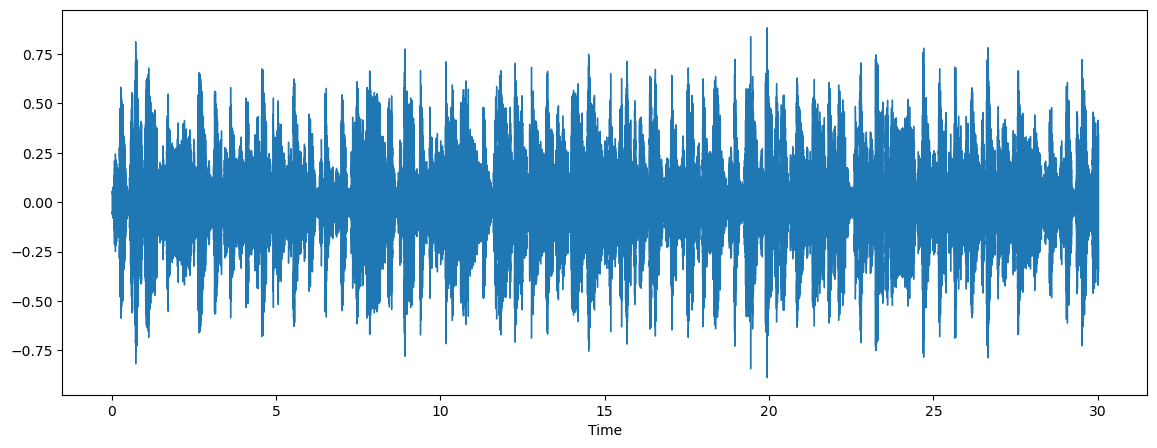

In [5]:
blues_path = 'Data/genres_original/blues/blues.00000.wav'
blues_audio = plot_sound(blues_path)
ipd.Audio(blues_path)

length (661794,), sample-rate 22050


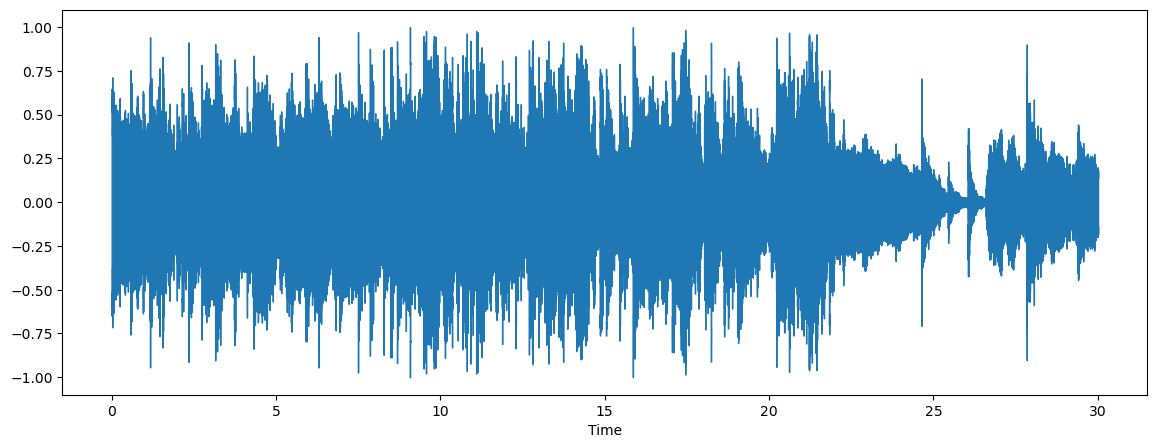

In [6]:
rock_path = 'Data/genres_original/rock/rock.00001.wav'
rock_audio = plot_sound(rock_path)
ipd.Audio(rock_path)

length (661504,), sample-rate 22050


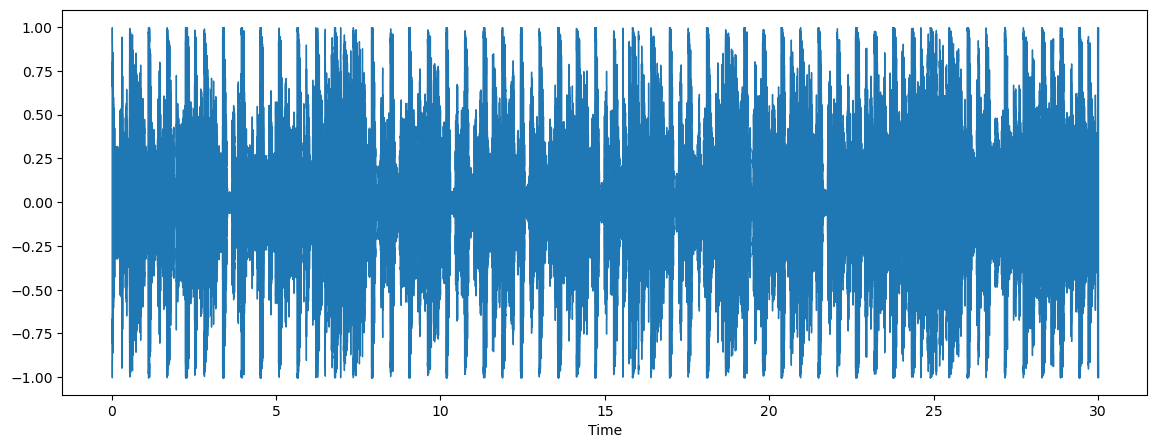

In [7]:
pop_path = 'Data/genres_original/pop/pop.00001.wav'
pop_audio = plot_sound(pop_path)
ipd.Audio(pop_path)

In [8]:
wave_sample_rate, wave_audio = wav.read(rock_path)

In [9]:
wave_sample_rate

22050

In [10]:
wave_audio

array([11875, 21282, 20701, ...,  1421,  1826,  1868], dtype=int16)

# Plot Spectrogram

A spectrogram is a visual way of representing the signal loudness, of a signal over time at various frequencies present in a particular waveform. Not only can one see whether there is more or less energy at, for example, 2 Hz vs 10 Hz, but one can also see how energy levels vary over time.

In [11]:
x, sr = librosa.load(pop_path)

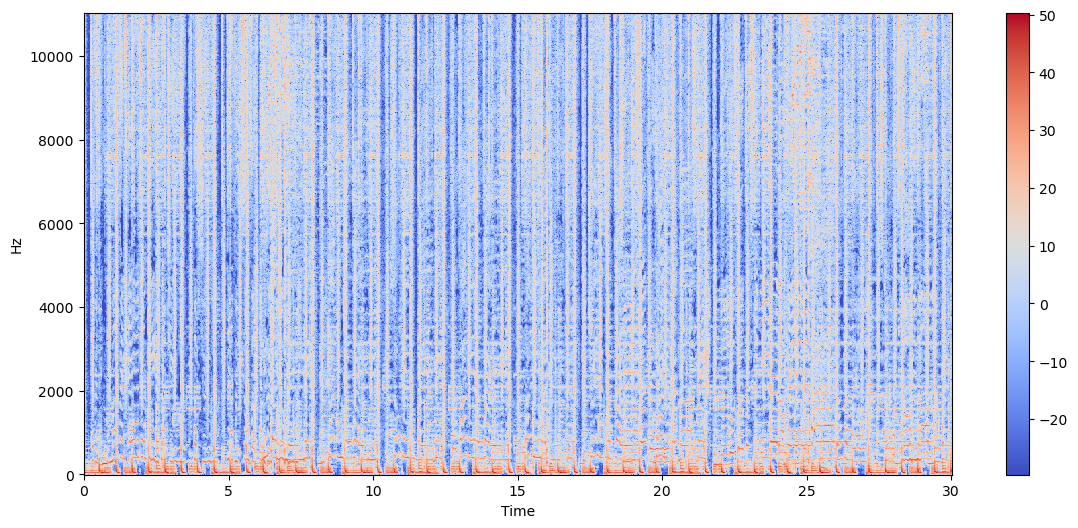

In [12]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 6))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

The vertical axis represents frequencies (from 0 to 10kHz), and the horizontal axis represents the time of the clip.

# Load Dataset


In [13]:
df = pd.read_csv('Data/features_3_sec.csv')
df.head()

filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.0.wav   66149          0.335406         0.091048  0.130405   
1  blues.00000.1.wav   66149          0.343065         0.086147  0.112699   
2  blues.00000.2.wav   66149          0.346815         0.092243  0.132003   
3  blues.00000.3.wav   66149          0.363639         0.086856  0.132565   
4  blues.00000.4.wav   66149          0.335579         0.088129  0.143289   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.003521             1773.065032          167541.630869   
1  0.001450             1816.693777           90525.690866   
2  0.004620             1788.539719          111407.437613   
3  0.002448             1655.289045          111952.284517   
4  0.001701             1630.656199           79667.267654   

   spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
0              1972.744388           117335.771563  ...   39.687145   
1              2010.051501            65671.875673  ...   64.748276   
2              2084.565132            75124.921716  ...   67.336563   
3              1960.039988            82913.639269  ...   47.739452   
4              1948.503884            60204.020268  ...   30.336359   

   mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  \
0    -3.241280   36.488243     0.722209   38.099152    -5.050335   33.618073   
1    -6.055294   40.677654     0.159015   51.264091    -2.837699   97.030830   
2    -1.768610   28.348579     2.378768   45.717648    -1.938424   53.050835   
3    -3.841155   28.337118     1.218588   34.770935    -3.580352   50.836224   
4     0.664582   45.880913     1.689446   51.363583    -3.392489   26.738789   

   mfcc20_mean  mfcc20_var  label  
0    -0.243027   43.771767  blues  
1     5.784063   59.943081  blues  
2     2.517375   33.105122  blues  
3     3.630866   32.023678  blues  
4     0.536961   29.146694  blues  

[5 rows x 60 columns]

We should first see how big our dataset is

In [14]:
df.shape

(9990, 60)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9990 entries, 0 to 9989
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   filename                 9990 non-null   object 
 1   length                   9990 non-null   int64  
 2   chroma_stft_mean         9990 non-null   float64
 3   chroma_stft_var          9990 non-null   float64
 4   rms_mean                 9990 non-null   float64
 5   rms_var                  9990 non-null   float64
 6   spectral_centroid_mean   9990 non-null   float64
 7   spectral_centroid_var    9990 non-null   float64
 8   spectral_bandwidth_mean  9990 non-null   float64
 9   spectral_bandwidth_var   9990 non-null   float64
 10  rolloff_mean             9990 non-null   float64
 11  rolloff_var              9990 non-null   float64
 12  zero_crossing_rate_mean  9990 non-null   float64
 13  zero_crossing_rate_var   9990 non-null   float64
 14  harmony_mean            

Let's check whther our dataset is balanced or not

In [16]:
df['label'].value_counts()

label
blues        1000
jazz         1000
metal        1000
pop          1000
reggae       1000
disco         999
classical     998
hiphop        998
rock          998
country       997
Name: count, dtype: int64

So our dataset is balanced dataset

#### Correlation Heatmap for feature means

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5, 26.5, 27.5]),
 [Text(0, 0.5, 'chroma_stft_mean'),
  Text(0, 1.5, 'rms_mean'),
  Text(0, 2.5, 'spectral_centroid_mean'),
  Text(0, 3.5, 'spectral_bandwidth_mean'),
  Text(0, 4.5, 'rolloff_mean'),
  Text(0, 5.5, 'zero_crossing_rate_mean'),
  Text(0, 6.5, 'harmony_mean'),
  Text(0, 7.5, 'perceptr_mean'),
  Text(0, 8.5, 'mfcc1_mean'),
  Text(0, 9.5, 'mfcc2_mean'),
  Text(0, 10.5, 'mfcc3_mean'),
  Text(0, 11.5, 'mfcc4_mean'),
  Text(0, 12.5, 'mfcc5_mean'),
  Text(0, 13.5, 'mfcc6_mean'),
  Text(0, 14.5, 'mfcc7_mean'),
  Text(0, 15.5, 'mfcc8_mean'),
  Text(0, 16.5, 'mfcc9_mean'),
  Text(0, 17.5, 'mfcc10_mean'),
  Text(0, 18.5, 'mfcc11_mean'),
  Text(0, 19.5, 'mfcc12_mean'),
  Text(0, 20.5, 'mfcc13_mean'),
  Text(0, 21.5, 'mfcc14_mean'),
  Text(0, 22.5, 'mfcc15_mean'),
  Text(0, 23.5, 'mfcc16_mean'),
  Text(0, 24.5, 

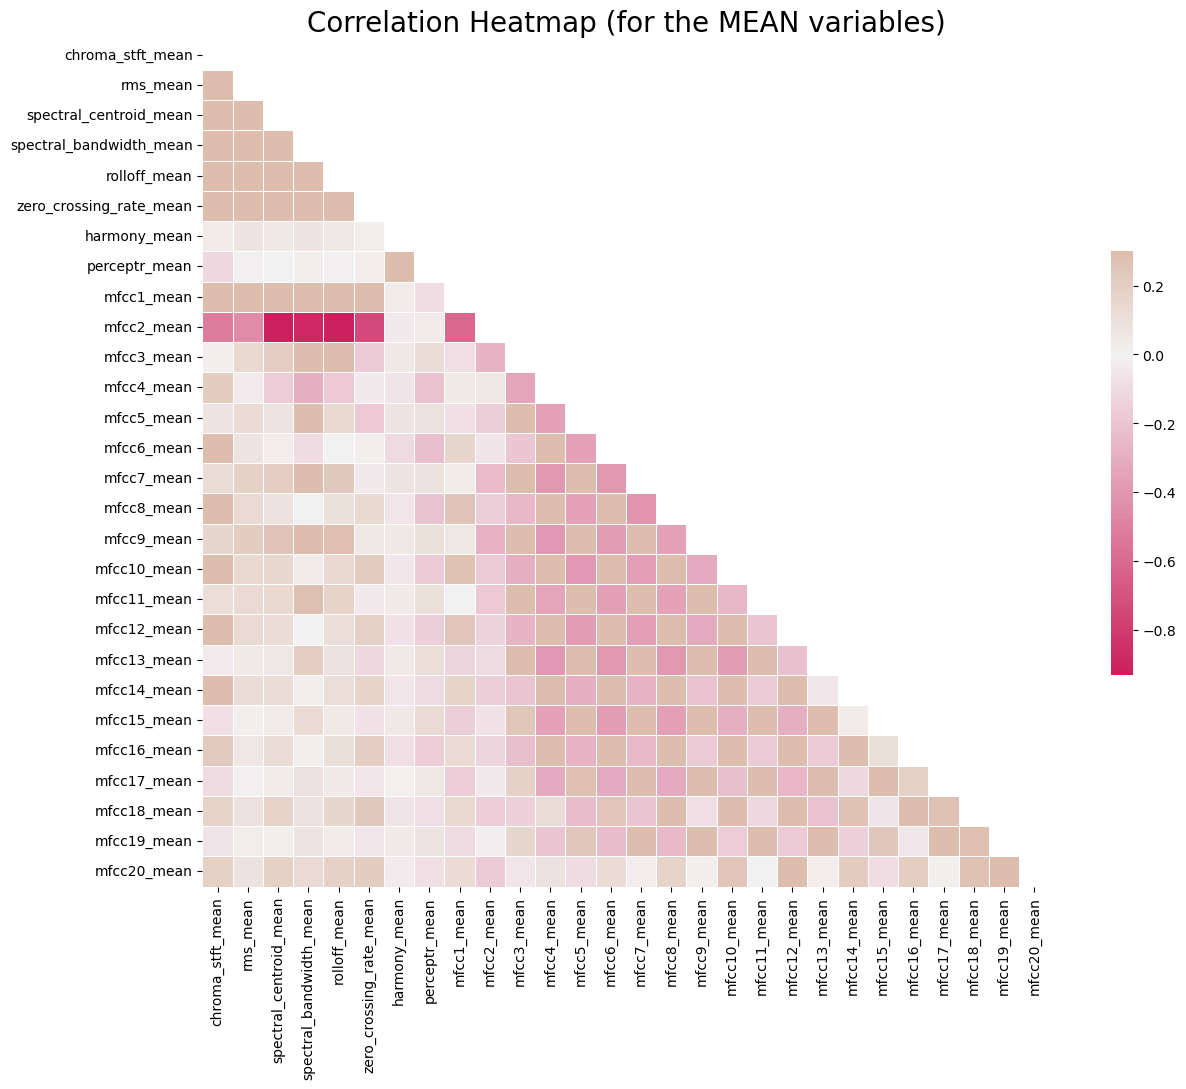

In [17]:
# Computing the Correlation Matrix
spike_cols = [col for col in df.columns if 'mean' in col]
corr = df[spike_cols].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))  # Utiliser 'bool' au lieu de 'np.bool'

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 11))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(0, 25, as_cmap=True, s=90, l=45, n=5)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap (for the MEAN variables)', fontsize=20)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

#### Box Plot for Genres Distributions

/var/folders/g9/jzqz957j1slb_dkhyp9fl5_w0000gn/T/ipykernel_69090/3760914025.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = "label", y = "tempo", data = x, palette = 'husl');


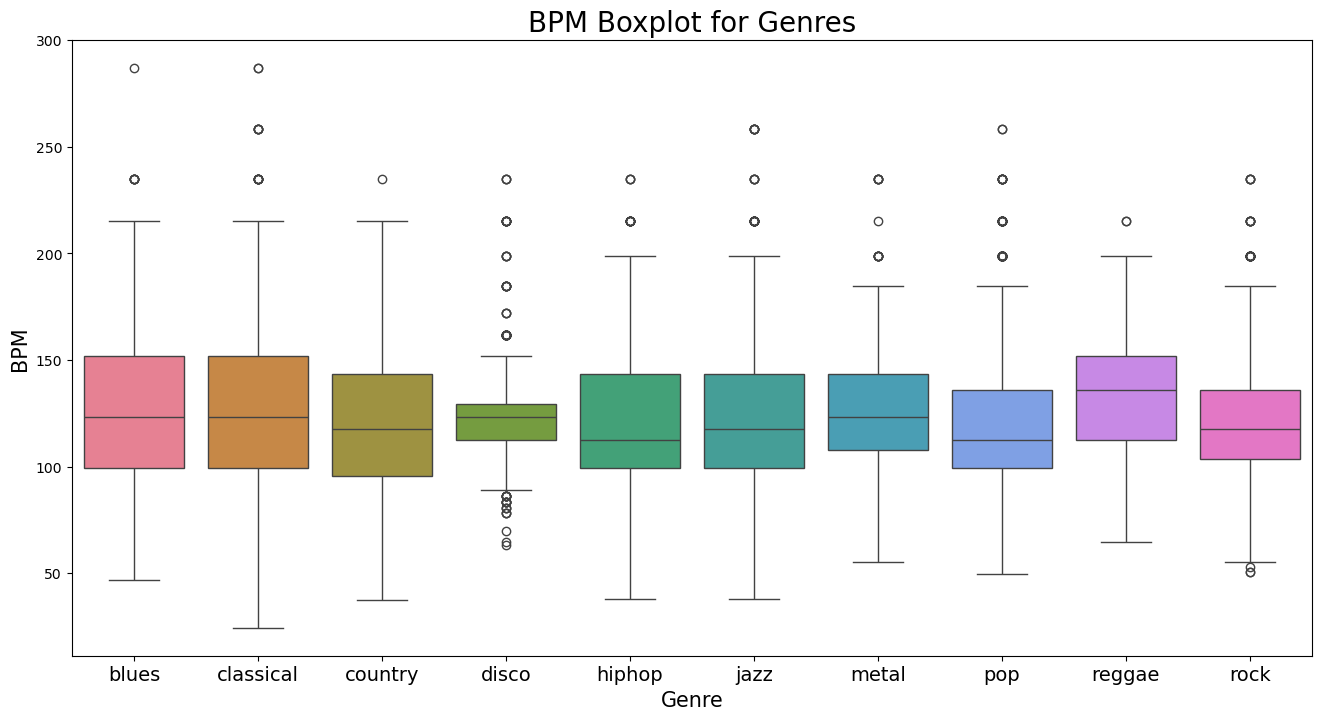

In [18]:
x = df[["label", "tempo"]]

fig, ax = plt.subplots(figsize=(16, 8));
sns.boxplot(x = "label", y = "tempo", data = x, palette = 'husl');

plt.title('BPM Boxplot for Genres', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Genre", fontsize = 15)
plt.ylabel("BPM", fontsize = 15)
plt.savefig("BPM_Boxplot.png")

# Data Preprocessing

Let's convert the **label** values into integers

In [19]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

In [20]:
import pickle

# Sauvegarde du LabelEncoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

**Independent and dependent variables**

In [21]:
X = df.drop(['label','filename'],axis=1)
y = df['label'] 

We are going to normalize our data

In [22]:
cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)

# Sauvegarder le scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(min_max_scaler, f)

# new data frame with the new scaled data. 
X = pd.DataFrame(np_scaled, columns = cols)

# Train-Test Split

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=111)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6993, 58), (2997, 58), (6993,), (2997,))

# Build ML Models

Below code is taken from this [link](https://www.kaggle.com/andradaolteanu/work-w-audio-data-visualise-classify-recommend)

In [24]:
def model_assess(model, title = "Default"):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    #print(confusion_matrix(y_test, preds))
    print('Accuracy', title, ':', round(accuracy_score(y_test, preds), 5), '\n')

We will going to make 11 models and then choose the best model

In [25]:
# Naive Bayes
nb = GaussianNB()
model_assess(nb, "Naive Bayes")

# Stochastic Gradient Descent
sgd = SGDClassifier(max_iter=5000, random_state=0)
model_assess(sgd, "Stochastic Gradient Descent")

# KNN
knn = KNeighborsClassifier(n_neighbors=19)
model_assess(knn, "KNN")

# Decission trees
tree = DecisionTreeClassifier()
model_assess(tree, "Decission trees")

# Random Forest
rforest = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)
model_assess(rforest, "Random Forest")

# Support Vector Machine
svm = SVC(decision_function_shape="ovo")
model_assess(svm, "Support Vector Machine")

# Logistic Regression
lg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
model_assess(lg, "Logistic Regression")

# Neural Nets
nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5000, 10), random_state=1)
model_assess(nn, "Neural Nets")

# catboost
cbc = cb.CatBoostClassifier(verbose=0, eval_metric='Accuracy', loss_function='MultiClass')
model_assess(cbc,"Cat Boost Classifier")

# Cross Gradient Booster
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
model_assess(xgb, "Cross Gradient Booster")

# Cross Gradient Booster (Random Forest)
xgbrf = XGBRFClassifier(objective= 'multi:softmax')
model_assess(xgbrf, "Cross Gradient Booster (Random Forest)")

Accuracy Naive Bayes : 0.51518 

Accuracy Stochastic Gradient Descent : 0.668 

Accuracy KNN : 0.80414 

Accuracy Decission trees : 0.66099 

Accuracy Random Forest : 0.80814 

Accuracy Support Vector Machine : 0.74775 



/Users/mathisgorvien/conda_envs/ia_deeplearning/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/mathisgorvien/conda_envs/ia_deeplearning/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy Logistic Regression : 0.68402 



/Users/mathisgorvien/conda_envs/ia_deeplearning/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Accuracy Neural Nets : 0.69369 

Accuracy Cat Boost Classifier : 0.90524 

Accuracy Cross Gradient Booster : 0.91091 

Accuracy Cross Gradient Booster (Random Forest) : 0.74908 



So we got highest accuracy with catboost model.Let's print the confusion matrix of it

Accuracy : 0.90524 



<Axes: >

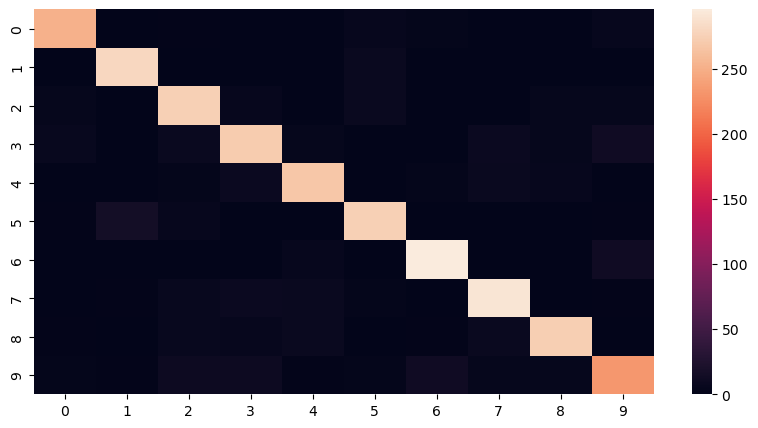

In [26]:
# Final model
cbc = cb.CatBoostClassifier(verbose=0, eval_metric='Accuracy', loss_function='MultiClass')
cbc.fit(X_train, y_train)


preds = cbc.predict(X_test)

print('Accuracy', ':', round(accuracy_score(y_test, preds), 5), '\n')

# Confusion Matrix
confus_mat = confusion_matrix(y_test, preds) 
plt.figure(figsize = (10, 5))
sns.heatmap(confus_mat)

# Deep Learning Model

Now it's time to build our deep learning model,so let's go ahead

In [27]:
X_train.shape[1]

58

In [28]:
model = Sequential()

model.add(Flatten(input_shape=(58,)))
model.add(Dense(512, activation='relu', kernel_regularizer = keras.regularizers.l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu', kernel_regularizer = keras.regularizers.l2(0.003)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu', kernel_regularizer = keras.regularizers.l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

/Users/mathisgorvien/conda_envs/ia_deeplearning/lib/python3.9/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 58)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        30,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 180,394 (704.66 KB)

 Trainable params: 180,394 (704.66 KB)

 Non-trainable params: 0 (0.00 B)

In order to prevent our model from overfitting we wll use callbacks

In [29]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

check_pointer = ModelCheckpoint(filepath='clf-resnet-checkpoint.weights.h5', 
                                 verbose=1, 
                                 save_best_only=True, 
                                 save_weights_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode='min', verbose=1, 
                              patience=5, min_delta=0.0001, factor=0.2)

callbacks = [check_pointer, early_stopping, reduce_lr]


In [30]:
# Compile the model with the correct parameter name
adam = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=adam,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])


Wuhhoo our model is ready let's train our model,let's run for 100 epochs

In [31]:
hist = model.fit(X_train, y_train,
                 validation_data = (X_test,y_test),
                 epochs = 100,
                 batch_size = 32, callbacks = [check_pointer,early_stopping])

# Sauvegarder le modèle
model.save('mon_modele.h5')

Epoch 1/100
209/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1192 - loss: 4.2409
Epoch 1: val_loss improved from inf to 3.61742, saving model to clf-resnet-checkpoint.weights.h5
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1202 - loss: 4.2306 - val_accuracy: 0.2416 - val_loss: 3.6174
Epoch 2/100
212/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2106 - loss: 3.4775
Epoch 2: val_loss improved from 3.61742 to 2.95195, saving model to clf-resnet-checkpoint.weights.h5
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2112 - loss: 3.4718 - val_accuracy: 0.3347 - val_loss: 2.9519
Epoch 3/100
211/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2926 - loss: 2.9048
Epoch 3: val_loss improved from 2.95195 to 2.50886, saving model to clf-resnet-checkpoint.weights.h5
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2932 - loss: 2.9005 - val_accuracy: 0.3764 - val_loss: 2.5089
Epoch 4/100
215/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3349 - loss: 2.5447
Ep

In [32]:
test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test accuracy: {test_accuracy}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.6914 - loss: 1.0733
Test accuracy: 0.6953620314598083


# Plot Accuracy and Loss

<Figure size 2000x1500 with 0 Axes>

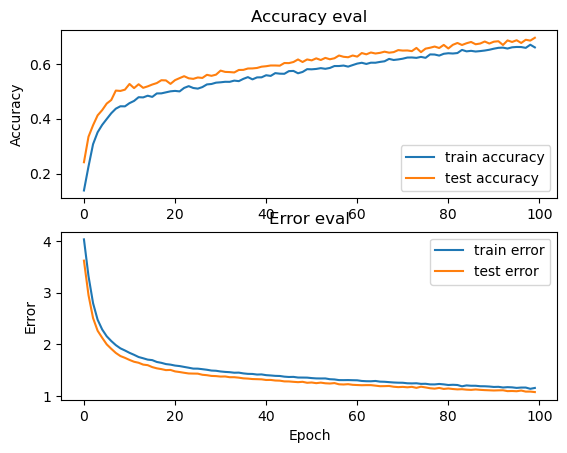

In [33]:
plt.figure(figsize=(20,15))
fig, axs = plt.subplots(2)

# accuracy 
axs[0].plot(hist.history["accuracy"], label="train accuracy")
axs[0].plot(hist.history["val_accuracy"], label="test accuracy")    
axs[0].set_ylabel("Accuracy")
axs[0].legend(loc="lower right")
axs[0].set_title("Accuracy eval")
    
# Error 
axs[1].plot(hist.history["loss"], label="train error")
axs[1].plot(hist.history["val_loss"], label="test error")    
axs[1].set_ylabel("Error")
axs[1].set_xlabel("Epoch")
axs[1].legend(loc="upper right")
axs[1].set_title("Error eval")
    
plt.show()

In [59]:
import yt_dlp as youtube_dl
import os

def download_youtube_audio(youtube_url, output_path="downloaded_audio.wav"):
    ydl_opts = {
        'format': 'bestaudio/best',
        'outtmpl': 'temp_audio.%(ext)s',
        'postprocessors': [{
            'key': 'FFmpegExtractAudio',
            'preferredcodec': 'wav',
            'preferredquality': '192',
        }],
    }
    
    # Télécharger l'audio
    with youtube_dl.YoutubeDL(ydl_opts) as ydl:
        ydl.download([youtube_url])
    
    # Renommer le fichier pour l'utiliser
    if os.path.exists("temp_audio.wav"):
        os.rename("temp_audio.wav", output_path)
        print(f"Audio téléchargé et sauvegardé sous : {output_path}")
    else:
        print("Erreur lors du téléchargement.")

# Exemple d'utilisation
youtube_url = "https://www.youtube.com/watch?v=pAgnJDJN4VA"
download_youtube_audio(youtube_url, "test_audio.wav")


[youtube] Extracting URL: https://www.youtube.com/watch?v=pAgnJDJN4VA
[youtube] pAgnJDJN4VA: Downloading webpage
[youtube] pAgnJDJN4VA: Downloading ios player API JSON
[youtube] pAgnJDJN4VA: Downloading mweb player API JSON
[youtube] pAgnJDJN4VA: Downloading m3u8 information
[info] pAgnJDJN4VA: Downloading 1 format(s): 251
[download] Destination: temp_audio.webm
[download] 100% of    3.83MiB in 00:00:00 at 8.57MiB/s   
[ExtractAudio] Destination: temp_audio.wav
Deleting original file temp_audio.webm (pass -k to keep)
Audio téléchargé et sauvegardé sous : test_audio.wav


In [66]:
def extract_features_from_segment(segment, sample_rate):
    try:
        # Chroma_stft
        chroma_stft = librosa.feature.chroma_stft(y=segment, sr=sample_rate)
        chroma_stft_mean = np.mean(chroma_stft)
        chroma_stft_var = np.var(chroma_stft)

        # RMS
        rms = librosa.feature.rms(y=segment)
        rms_mean = np.mean(rms)
        rms_var = np.var(rms)

        # Spectral Centroid
        spec_cent = librosa.feature.spectral_centroid(y=segment, sr=sample_rate)
        spec_cent_mean = np.mean(spec_cent)
        spec_cent_var = np.var(spec_cent)

        # Spectral Bandwidth
        spec_bw = librosa.feature.spectral_bandwidth(y=segment, sr=sample_rate)
        spec_bw_mean = np.mean(spec_bw)
        spec_bw_var = np.var(spec_bw)

        # Roll-off
        rolloff = librosa.feature.spectral_rolloff(y=segment, sr=sample_rate)
        rolloff_mean = np.mean(rolloff)
        rolloff_var = np.var(rolloff)

        # Zero Crossing Rate
        zcr = librosa.feature.zero_crossing_rate(segment)
        zcr_mean = np.mean(zcr)
        zcr_var = np.var(zcr)

        # Harmony
        harmony = librosa.effects.harmonic(segment)
        harmony_mean = np.mean(harmony)
        harmony_var = np.var(harmony)

        # Percussive
        perceptr = librosa.effects.percussive(segment)
        perceptr_mean = np.mean(perceptr)
        perceptr_var = np.var(perceptr)

        # Tempo
        tempo_array = librosa.beat.tempo(y=segment, sr=sample_rate)
        tempo = float(tempo_array[0]) if len(tempo_array) > 0 else 0.0
        tempo_var = 0.0  # Var du tempo (peut rester à 0)

        # MFCCs
        mfcc = librosa.feature.mfcc(y=segment, sr=sample_rate, n_mfcc=20)
        mfccs_mean = np.mean(mfcc, axis=1)
        mfccs_var = np.var(mfcc, axis=1)

        # Combiner les caractéristiques
        features = np.array([
            chroma_stft_mean, chroma_stft_var,
            rms_mean, rms_var,
            spec_cent_mean, spec_cent_var,
            spec_bw_mean, spec_bw_var,
            rolloff_mean, rolloff_var,
            zcr_mean, zcr_var,
            harmony_mean, harmony_var,
            perceptr_mean, perceptr_var,
            tempo, tempo_var
        ])

        features = np.concatenate((features, mfccs_mean, mfccs_var))
        return features

    except Exception as e:
        print("Erreur lors de l'extraction des caractéristiques du segment :", e)
        return None


In [67]:
!pip install resampy

In [68]:
from tensorflow.keras.models import load_model

# Charger le modèle
model = load_model('mon_modele.h5')

# Extraire les caractéristiques du fichier audio de test
test_audio_features = extract_features_58("test_audio.wav")

if test_audio_features is not None:
    test_audio_features = np.array(test_audio_features)
    test_audio_features = test_audio_features.reshape(1, -1)  # Reshape en (1, 58) ou (1, 57)
    print(f"Forme des données d'entrée pour le modèle : {test_audio_features.shape}")

    # Charger le scaler et normaliser les données
    with open('scaler.pkl', 'rb') as f:
        min_max_scaler = pickle.load(f)
    test_audio_features = min_max_scaler.transform(test_audio_features)

    # Charger le modèle
    model = load_model('mon_modele.h5')

    # Faire la prédiction
    prediction = model.predict(test_audio_features)
    predicted_index = np.argmax(prediction, axis=1)[0]

    # Charger le LabelEncoder
    with open('label_encoder.pkl', 'rb') as f:
        label_encoder = pickle.load(f)

    # Obtenir le nom du genre prédit
    predicted_genre = label_encoder.inverse_transform([predicted_index])
    print(f"Le genre prédit est : {predicted_genre[0]}")
else:
    print("Les caractéristiques n'ont pas pu être extraites.")

/var/folders/g9/jzqz957j1slb_dkhyp9fl5_w0000gn/T/ipykernel_69090/1091623618.py:47: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  tempo_array = librosa.beat.tempo(y=X, sr=sample_rate)
/Users/mathisgorvien/conda_envs/ia_deeplearning/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Nombre de caractéristiques extraites : 58
Forme des données d'entrée pour le modèle : (1, 58)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Le genre prédit est : hiphop


In [ ]:
def extract_features_from_audio(file_name, segment_duration=3):
    try:
        # Charger l'audio complet
        X, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
        total_duration = librosa.get_duration(y=X, sr=sample_rate)
        
        features_list = []
        for start in range(0, int(total_duration), segment_duration):
            # Extraire un segment de segment_duration secondes
            end = start + segment_duration
            if end > total_duration:
                break  # Ignorer les segments incomplets
            segment = X[int(start * sample_rate):int(end * sample_rate)]
            
            # Extraire les caractéristiques du segment
            features = extract_features_from_segment(segment, sample_rate)
            if features is not None:
                features_list.append(features)
        
        return features_list
    except Exception as e:
        print("Erreur lors de l'extraction des caractéristiques :", e)
        return None

def extract_features_from_segment(segment, sample_rate):
    try:
        # Extraire les caractéristiques du segment
        # Utilisez le même code que dans votre fonction extract_features_58,
        # en utilisant le segment au lieu de X
        # ...
        # Retournez les caractéristiques extraites
        return features
    except Exception as e:
        print("Erreur lors de l'extraction des caractéristiques du segment :", e)
        return None
